# Introduction

In this notebook, we'll simply load the data, downcast it using a technique I learned from [this](https://www.kaggle.com/code/vaibhavgupta082/time-series-forecasting-eda-fe-modelling-679c92) notebook and do some pre-processsing work before analysis

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

In [2]:
# GLOBAL VARIABLES
DATA_PATH = "../../m5-data/"

WALMART_COLOURS = ["#0072CE", "#B4B4B3", "#79B8F3", "#FDB927", "#F7941D", "#4CB748", "#2E3192"]
DIVERGENT_COLOUR_GRADIENT = ["#e2f1fc", "#b9dcfa", "#8cc7f7", "#5eb1f3", "#39a0f1", "#0691ef"]
sns.set_palette(WALMART_COLOURS)


In [3]:
# data paths
sales_path = os.path.join(DATA_PATH, "sales_train_evaluation.csv")
calendar_path = os.path.join(DATA_PATH, "calendar.csv")
prices_path = os.path.join(DATA_PATH, "sell_prices.csv")

In [4]:
sales = pd.read_csv(sales_path)
calendar = pd.read_csv(calendar_path)
prices = pd.read_csv(prices_path)

In [5]:
#Add zero sales for the remaining days 1942-1969
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

In [7]:
def get_df_memory(df):
  return np.round(df.memory_usage().sum()/(1024*1024),1)

def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df 

In [7]:
sales_bd = get_df_memory(sales)
calendar_bd = get_df_memory(calendar)
prices_bd = get_df_memory(prices)

In [8]:
sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

In [9]:
sales_ad = get_df_memory(sales)
calendar_ad = get_df_memory(calendar)
prices_ad = get_df_memory(prices)

In [10]:
memory = {'DataFrame':['sales','calendar','prices'],
       'Before downcasting':[sales_bd,calendar_bd,prices_bd],
       'After downcasting':[sales_ad,calendar_ad,prices_ad]}

memory = pd.DataFrame(memory)
memory = pd.melt(memory, id_vars='DataFrame', var_name='Status', value_name='Memory (MB)')
memory.sort_values('Memory (MB)',inplace=True)
fig = px.bar(memory, x='DataFrame', y='Memory (MB)', color='Status', color_discrete_sequence=WALMART_COLOURS, barmode='group', text='Memory (MB)')
fig.update_traces(texttemplate='%{text} MB', textposition='outside')
fig.update_layout(template='seaborn', title='Effect of Downcasting')
fig.show()

### Understanding The Data

Now that we've downcasted the data, we can now trying and wrap our heads around what's in the data. The M5 dataset, generously made available by Walmart, involves the unit sales of various products sold in the USA, organized in the form of **grouped time series**. We have 3 049 products classified into 3 product categories (Hobbies, Foods and Household). We then have 7 product department in under which these categories are aggregated.
These products are sold in 10 stores across 3 states: California(CA), Texas(TA) and Wisconsin(WI).

We can visualize this distribution as follows:

In [9]:
sales_group = sales.groupby(['state_id','store_id','cat_id','dept_id'],as_index=False)['item_id'].count().dropna()
sales_group.head()

,state_id,store_id,cat_id,dept_id,item_id
0,CA,CA_1,FOODS,FOODS_1,216
1,CA,CA_1,FOODS,FOODS_2,398
2,CA,CA_1,FOODS,FOODS_3,823
3,CA,CA_1,FOODS,HOBBIES_1,0
4,CA,CA_1,FOODS,HOBBIES_2,0


In [9]:
group = sales.groupby(['state_id','store_id','cat_id','dept_id'],as_index=False)['item_id'].count().dropna()
group = group[group['item_id'] > 0].reset_index(drop=True) # removing zero-valued rows
group['USA'] = 'United States of America'
group.rename(columns={'state_id':'State','store_id':'Store','cat_id':'Category','dept_id':'Department','item_id':'Count'},inplace=True)
fig = px.treemap(
  group, 
  path=['USA', 'State', 'Store', 'Category', 'Department'], 
  values='Count',
  color='Count',
  color_continuous_scale= DIVERGENT_COLOUR_GRADIENT,
  title="Walmart's Item Distribution"
)
fig.update_layout(template='seaborn')
fig.show()

We learn from the above graph that items are distributed in a similar manner across states, stores and product departments; all 3 states under analysis have the same number of products across stores and product categories. A curious question might be: do they really sell the same products? For now, I don't think it's worthwhile to answer this question.

The above graph also suggests the logic in which we can explore the data. +3000 products is a really a lot and thus needs systematic approach to analysis.

In [10]:
sales.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966',
       'd_1967', 'd_1968', 'd_1969'],
      dtype='object', length=1975)

In [10]:
mlt_sales = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

In [11]:
mlt_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [12]:
mlt_sales = pd.merge(mlt_sales, calendar[['date', 'd']], on='d', how='left')
mlt_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29


In [25]:
mlt_sales['date'] = pd.to_datetime(mlt_sales['date'])
mlt_sales = mlt_sales.set_index('date')

KeyError: 'date'

In [14]:
daily_total_sales = mlt_sales.groupby('date')['sold'].sum()
daily_total_sales.head()

date
2011-01-29    32631
2011-01-30    31749
2011-01-31    23783
2011-02-01    25412
2011-02-02    19146
Name: sold, dtype: int64

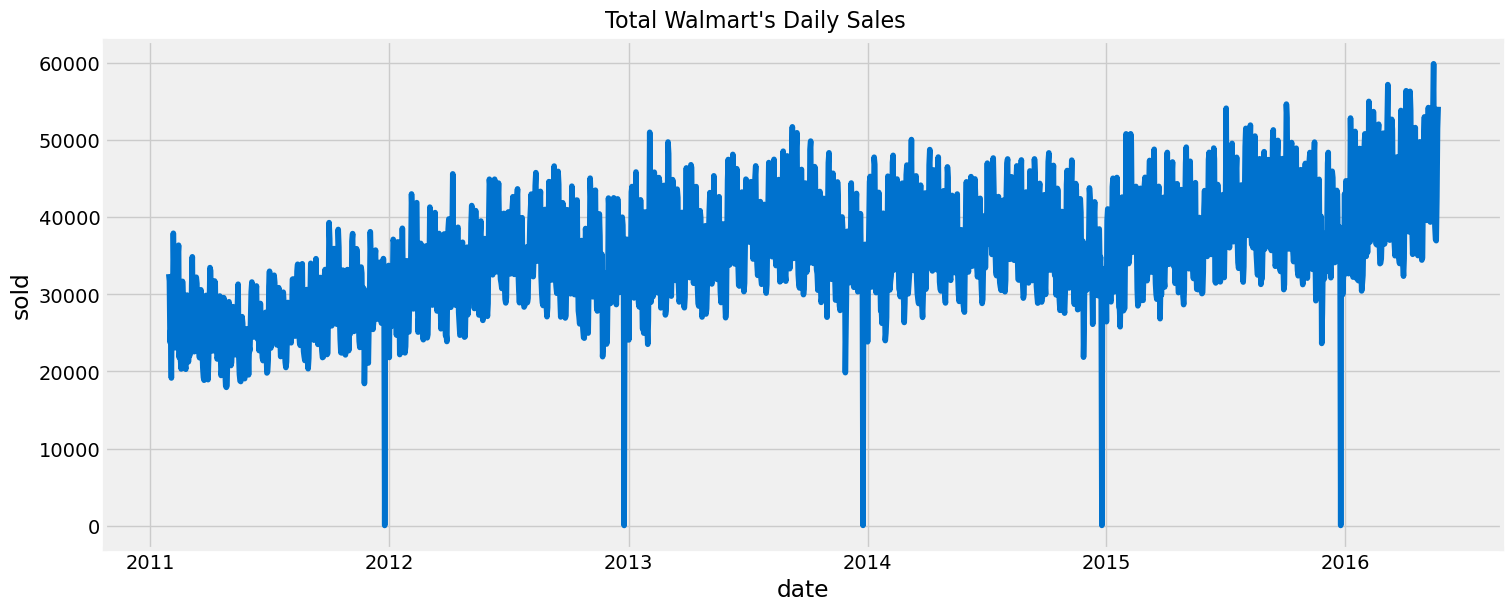

In [15]:
fig, ax = plt.subplots(figsize=(15, 6), layout="constrained")
_ = sns.lineplot(data=daily_total_sales, ax=ax)
_ = fig.suptitle("Total Walmart's Daily Sales", fontsize=16)

The time series under consideration show a slightly increasing trend with yearly seasonality; with the exception of 2011, we seem to have a concave shape in a year where total sales start at a certain point, grow until somewhere after mid-year where a decline is seen. This decline consistently ends with a very sharp drop every year. I've checked and learned that it's the 25 of December every year(as expected) where the sales drop to about 20 per day. Which is a very weird thing to happen; from an average of 3000 sales per day to 20 is just weird. My initial thought would be that this is probably a simulated dataset, but then again, I don't live in the US, so I don't know how things go over there.

Back to 2011; it's different because in the period of the year when the total sales peak, this was when they were rock-bottom in 2011. This is probably irrelavant for future forecasting.

So far, then I suppose we should check the kinds of holidays marked in the `calendar` dataset, because I still maintain we should have a feature specific to checking whether the date is the 25th of December or not.

In [35]:
daily_total_sales[daily_total_sales.values < 100]

,sold
date,
2011-12-25,13
2012-12-25,11
2013-12-25,20
2014-12-25,20
2015-12-25,14
2016-05-23,0
2016-05-24,0
2016-05-25,0
2016-05-26,0


In [32]:
calendar['date'] = pd.to_datetime(calendar['date'])
calendar.set_index('date', inplace=True)
calendar['is_christmas'] = ((calendar.index.month == 12) & (calendar.index.day == 25)).astype(int)
calendar.head()

,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,is_christmas
date,,,,,,,,,,,,,,
2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,0
2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,0
2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,0
2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,0
2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,0


In [30]:
mlt_sales['is_christmas'] = ((mlt_sales.index.month == 12) & (mlt_sales.index.day == 25)).astype(int)

In [31]:
mlt_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,is_christmas
date,,,,,,,,,
2011-01-29,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,0
2011-01-29,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,0
2011-01-29,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,0
2011-01-29,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,0
2011-01-29,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,0
